In [1]:
import sys,os
path = '/nfs/team283/aa16/KR_NAS/'
os.chdir(path)
sys.path.append(path)
import scanpy as sc
import anndata
import pandas as pd
import numpy as np
import gc
import pickle
data_type = 'float32'
os.environ["THEANO_FLAGS"] = 'device=cuda0, floatX=' + data_type + ', force_device=True, dnn.enabled=False'
import matplotlib as mpl
from matplotlib import rcParams
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype'] = 42
import cell2location as c2l

Can not use cuDNN on context None: Disabled by dnn.enabled flag
Mapped name None to device cuda0: Tesla V100-SXM2-32GB (0000:62:00.0)
OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


In [2]:
sp_data_folder = "/nfs/team283/aa16/KR_NAS/data/"
sc_data_folder = "/nfs/team283/brainData/human_fetal/Bhaduri2021/"
results_folder = "/nfs/team283/aa16/KR_NAS/CellLocationResults/"

In [3]:
adata_wta = sc.read_h5ad(sp_data_folder + "CR_cells_AnnData.h5ad")

In [4]:
adata_sc = sc.read_h5ad(sc_data_folder + 'wholebrain_doublet_free_v2_matrices_annotated.h5ad')

In [5]:
subset = adata_sc.obs['individual'] == 'GW17'
adata_sc = adata_sc[subset,:]
subset = adata_sc.obs['celltype'] != 'Outlier'
adata_sc = adata_sc[subset,:]

In [6]:
adata_sc.obs['clustercelltype'] = adata_sc.obs['celltype'].astype(str) + ' (cluster: ' + adata_sc.obs['cluster'].astype(str) + ')'

Trying to set attribute `.obs` of view, copying.


In [7]:
adata_sc.obs['clustercelltype'].value_counts()

Neuron (cluster: 15)      308
Neuron (cluster: 10)      302
Neuron (cluster: 28)      235
Neuron (cluster: 19)      207
Neuron (cluster: 20)      195
Neuron (cluster: 18)      192
Neuron (cluster: 29)      189
Neuron (cluster: 4)       186
Neuron (cluster: 26)      129
Neuron (cluster: 32)      126
CR (cluster: 8)           124
RG (cluster: 24)          120
Dividing (cluster: 35)    116
IPC (cluster: 22)         105
Dividing (cluster: 30)    105
RG (cluster: 9)            99
RG (cluster: 6)            99
RG (cluster: 17)           93
Dividing (cluster: 16)     91
Dividing (cluster: 27)     87
Dividing (cluster: 2)      86
Dividing (cluster: 25)     77
Neuron (cluster: 34)       72
IPC (cluster: 13)          66
Dividing (cluster: 36)     66
Vascular (cluster: 14)     62
Dividing (cluster: 31)     61
Vascular (cluster: 12)     55
Vascular (cluster: 11)     50
RG (cluster: 1)            50
Dividing (cluster: 3)      43
IPC (cluster: 23)          41
Vascular (cluster: 5)      39
Vascular (

In [8]:
adata_sc.raw = adata_sc

In [9]:
aver = c2l.cluster_averages.cluster_averages.compute_cluster_averages(adata_sc, 'clustercelltype')

In [10]:
adata_wta.var_names = adata_wta.var['SYMBOL'] 

In [11]:
adata_wta.var = adata_wta.var.drop(columns = 'SYMBOL')

In [12]:
adata_wta.raw = adata_wta

In [13]:
sc.settings.set_figure_params(dpi = 100, color_map = 'viridis', dpi_save = 100,
                              vector_friendly = True, format = 'pdf',
                              facecolor='white')

r = c2l.run_cell2location(

      # Single cell reference signatures as pd.DataFrame
      # (could also be data as anndata object for estimating signatures
      #  as cluster average expression - `sc_data=adata_snrna_raw`)
      sc_data=aver,
      # Spatial data as anndata object
      sp_data=adata_wta,
      model_name= c2l.models.LocationModelWTA,
      ignore_deprecation_exception=True,

      # the column in sc_data.obs that gives cluster idenitity of each cell
      summ_sc_data_args={'cluster_col': "celltype-cluster"},

      train_args={'use_raw': True, # By default uses raw slots in both of the input datasets.
                  'n_iter': 20000, # Increase the number of iterations if needed (see QC below)
                 }, # Column in sp_data.obs with experiment ID (see above)


      export_args={'path': results_folder, # path where to save results
                   'run_name_suffix': '' # optinal suffix to modify the name the run
                  },

      model_kwargs={ # Prior on the number of cells, cell types and co-located groups

                    'cell_number_prior': {
                        # - N - the expected number of cells per location:
                        'cells_per_spot': np.array(adata_wta.obs['nuclei']).reshape(len(adata_wta.obs['nuclei']),1), # < - change this
                        # - A - the expected number of cell types per location (use default):
                        'factors_per_spot': 7,
                        # - Y - the expected number of co-located cell type groups per location (use default):
                        'combs_per_spot': 7
                    },

                     # Prior beliefs on the sensitivity of spatial technology:
                    'gene_level_prior':{
                        # Prior on the mean
                        'mean': 1/2,
                        # Prior on standard deviation,
                        # a good choice of this value should be at least 2 times lower that the mean
                        'sd': 1/4
                    },
          'Y_data': np.array(adata_wta.obsm['negProbes'])
      },

)

### Summarising single cell clusters ###
### Creating model ### - time 0.0 min
### Analysis name: LocationModelWTA_1experiments_35clusters_145locations_17746genes
### Training model ###


IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

Finished [100%]: Average Loss = 7.1224e+06


  0%|          | 0/24 [00:00<?, ?it/s]

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [13]:
cell_density = pd.read_csv('/nfs/team283/aa16/KR_NAS/CellLocationResults/LocationModelWTA_1experiments_35clusters_145locations_17746genes/W_cell_density.csv',
                           index_col = 0)

In [27]:
#   cell_density = (cell_density.T/np.sum(cell_density, axis = 1).T).T
# cell_density.loc[adata_wta.obs.index[adata_wta.obs['Pool'] == 'CRcells'],:].sort_values(
#     'mean_spot_factorsCR (cluster: 8)').to_csv('/nfs/team283/aa16/KR_NAS/0_publication_tables/CR_cell_density.csv')

In [42]:
adata_wta.obs['Donor'] = [x.split('-')[0] for x in adata_wta.obs['Sample slide ID']]
adata_wta.obs['TissuePoolDonor'] = adata_wta.obs['Tissue'].astype(str) + ' ' + adata_wta.obs['Pool'].astype(str) + ' ' + adata_wta.obs['Donor'].astype(str)

In [43]:
input_data = np.array([np.sum(cell_density.loc[adata_wta.obs['TissuePoolDonor'] == x, :], axis = 0) for x in np.unique(adata_wta.obs['TissuePoolDonor'])])
density_tidy = pd.DataFrame(data = input_data,
                            index = np.unique(adata_wta.obs['TissuePoolDonor']),
                            columns = [c.split('mean_spot_factors')[1] for c in cell_density.columns])
density_tidy = (density_tidy.T/np.sum(density_tidy, axis = 1).T).T

In [44]:
adata_wta = adata_wta[[p in ('CRcells', 'Residual') for p in adata_wta.obs['Pool']],:]

In [45]:
main_types = np.array([c.split('(')[0] for c in density_tidy.columns])
main_types_unique = np.unique(main_types)

In [46]:
density_short = pd.DataFrame(
                            index = np.unique(adata_wta.obs['TissuePoolDonor']),
                            columns = main_types_unique)
for i in range(len(main_types_unique)):
    density_short.loc[:,main_types_unique[i]] = np.sum(density_tidy.loc[:,main_types == main_types_unique[i]], axis = 1)

In [47]:
order = ['Foetal brain (frontal lobe) CRcells Hob7', 'Foetal brain (frontal lobe) CRcells Hob8',
        'Foetal brain (occipital lobe) CRcells Hob7', 'Foetal brain (occipital lobe) CRcells Hob8',
        'Foetal brain (parietal lobe) CRcells Hob7', 'Foetal brain (parietal lobe) CRcells Hob8',
        'Foetal brain (temporal lobe) CRcells Hob7', 'Foetal brain (temporal lobe) CRcells Hob8',
        'Foetal brain (frontal lobe) Residual Hob7', 'Foetal brain (frontal lobe) Residual Hob8',
        'Foetal brain (occipital lobe) Residual Hob7', 'Foetal brain (occipital lobe) Residual Hob8',
        'Foetal brain (parietal lobe) Residual Hob7', 'Foetal brain (parietal lobe) Residual Hob8',
        'Foetal brain (temporal lobe) Residual Hob7', 'Foetal brain (temporal lobe) Residual Hob8']
density_short.loc[order,:]

CR   Dividing       IPC   \
Foetal brain (frontal lobe) CRcells Hob7     0.785452   0.078012  0.030306   
Foetal brain (frontal lobe) CRcells Hob8     0.892247   0.025638  0.009723   
Foetal brain (occipital lobe) CRcells Hob7   0.893609   0.028397  0.011995   
Foetal brain (occipital lobe) CRcells Hob8   0.781279   0.078662  0.027077   
Foetal brain (parietal lobe) CRcells Hob7    0.869926   0.049653  0.015653   
Foetal brain (parietal lobe) CRcells Hob8    0.623802   0.123421  0.057044   
Foetal brain (temporal lobe) CRcells Hob7    0.944205   0.022894  0.003732   
Foetal brain (temporal lobe) CRcells Hob8    0.628024   0.140720  0.056029   
Foetal brain (frontal lobe) Residual Hob7    0.003731   0.316068  0.131577   
Foetal brain (frontal lobe) Residual Hob8    0.002290   0.210487  0.134456   
Foetal brain (occipital lobe) Residual Hob7  0.005096   0.230481  0.151586   
Foetal brain (occipital lobe) Residual Hob8  0.003445   0.301595  0.165184   
Foetal brain (parietal lobe) Residual Hob7   0.008258   0.299610  0.137865   
Foetal brain (parietal lobe) Residual Hob8   0.001504   0.332057  0.173358   
Foetal brain (temporal lobe) Residual Hob7   0.003974   0.283719  0.146988   
Foetal brain (temporal lobe) Residual Hob8   0.009631   0.374715  0.183786   

                                              Neuron        RG   Vascular   
Foetal brain (frontal lobe) CRcells Hob7     0.057181  0.042354   0.006695  
Foetal brain (frontal lobe) CRcells Hob8     0.060718  0.007865   0.003808  
Foetal brain (occipital lobe) CRcells Hob7   0.051623  0.011976   0.002399  
Foetal brain (occipital lobe) CRcells Hob8   0.092851  0.018638   0.001493  
Foetal brain (parietal lobe) CRcells Hob7    0.048535  0.014854   0.001380  
Foetal brain (parietal lobe) CRcells Hob8    0.174212  0.019388   0.002133  
Foetal brain (temporal lobe) CRcells Hob7    0.017732  0.010123   0.001314  
Foetal brain (temporal lobe) CRcells Hob8    0.080880  0.081227   0.013120  
Foetal brain (frontal lobe) Residual Hob7    0.442225  0.095966   0.010434  
Foetal brain (frontal lobe) Residual Hob8    0.613082  0.015991   0.023695  
Foetal brain (occipital lobe) Residual Hob7  0.588514  0.014049   0.010273  
Foetal brain (occipital lobe) Residual Hob8  0.497206  0.018021   0.014548  
Foetal brain (parietal lobe) Residual Hob7   0.503385  0.045153   0.005729  
Foetal brain (parietal lobe) Residual Hob8   0.454503  0.032083   0.006495  
Foetal brain (temporal lobe) Residual Hob7   0.510392  0.050112   0.004816  
Foetal brain (temporal lobe) Residual Hob8   0.277506  0.111530   0.042832

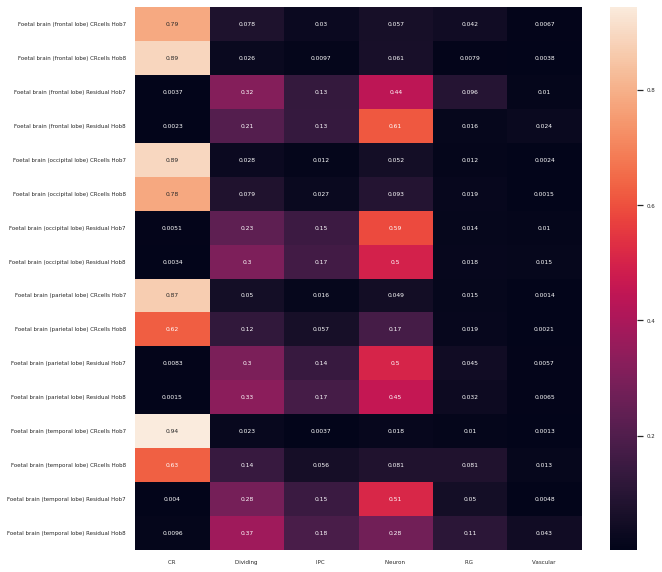

In [48]:
sns.set(font_scale=0.5)
fig, ax = plt.subplots(figsize=(10,10))   
sns.heatmap(density_short,
            annot=True,
           ax = ax)
plt.savefig('/nfs/team283/aa16/KR_NAS/CellLocationResults/LocationModelWTA_1experiments_35clusters_145locations_17746genes/CRcells_proportions_heatmap.pdf')

Maybe a bar plot is better:

In [49]:
main_types = np.array([c.split('(')[0] for c in density_tidy.columns])
main_types_unique = np.unique(main_types)

In [50]:
two_cell_density = pd.DataFrame(index = cell_density.index, columns = ('CR', 'Other'))
two_cell_density.loc[:,'CR'] = np.sum(cell_density.loc[:,main_types == 'CR '], axis = 1)
two_cell_density.loc[:,'Other'] = np.sum(cell_density.loc[:,main_types != 'CR '], axis = 1)
two_cell_density = (two_cell_density.T/np.sum(two_cell_density, axis = 1)).T

In [51]:
df = pd.DataFrame(columns = ["ROItype", "Celltype", "Donor", "BrainRegion"])
df['ROItype'] = adata_wta.obs['Pool']
df['Celltype'] =  np.repeat('CR', len(adata_wta.obs['Pool']))
df['Donor'] = adata_wta.obs['Donor']
df['BrainRegion'] = adata_wta.obs['Tissue']
df['Fraction'] = two_cell_density.loc[adata_wta.obs_names,'CR']

In [52]:
df['Donor'].loc[df['Donor'] == 'Hob8'] = '1'
df['Donor'].loc[df['Donor'] == 'Hob7'] = '2'

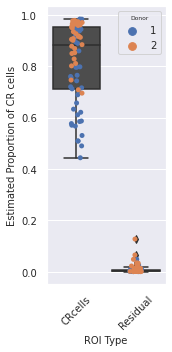

In [53]:
import matplotlib
import matplotlib.pyplot as plt

SMALL_SIZE = 10
MEDIUM_SIZE = 10
BIGGER_SIZE = 10

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title
fig, ax = plt.subplots(1,1,figsize = (2.5,5))
sns.stripplot(x="ROItype", y="Fraction", data=df, hue = 'Donor',  ax = ax)
sns.boxplot(x="ROItype", y="Fraction", data=df, color=".3", ax = ax)
ax.set_ylabel('Estimated Proportion of CR cells', size = 10)
ax.set_xlabel('ROI Type', size = 10)
plt.xticks(rotation=45)
plt.tight_layout()

plt.savefig('/nfs/team283/aa16/KR_NAS/CellLocationResults/LocationModelWTA_1experiments_35clusters_145locations_17746genes/CRcells_proportions_barplot_general.pdf')

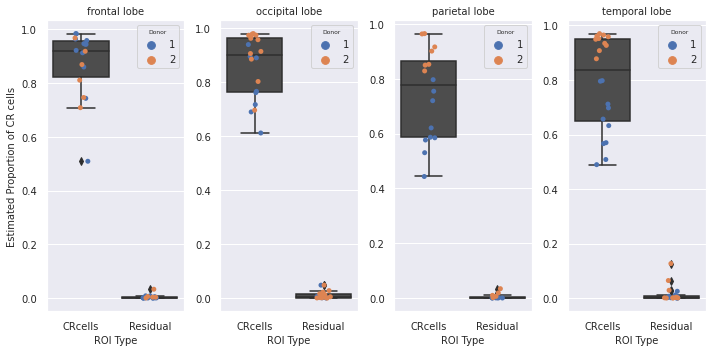

In [54]:
import matplotlib
import matplotlib.pyplot as plt

SMALL_SIZE = 10
MEDIUM_SIZE = 10
BIGGER_SIZE = 10

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

fig, ax = plt.subplots(1,4,figsize = (10,5))

unique_regions = np.unique(df['BrainRegion'])

for i in range(len(unique_regions)):
    sns.stripplot(x="ROItype", y="Fraction", data=df.loc[df['BrainRegion'] == unique_regions[i],:], hue = 'Donor',  ax = ax[i])
    sns.boxplot(x="ROItype", y="Fraction", data=df.loc[df['BrainRegion'] == unique_regions[i],:], color=".3", ax = ax[i])
    if i == 0:
        ax[i].set_ylabel('Estimated Proportion of CR cells', size = 10)
    else:
        ax[i].set_ylabel(None)
    ax[i].set_xlabel('ROI Type', size = 10)
    ax[i].set_title(unique_regions[i].split('(')[1].split(')')[0])
    plt.tight_layout()
plt.savefig('/nfs/team283/aa16/KR_NAS/CellLocationResults/LocationModelWTA_1experiments_35clusters_145locations_17746genes/CRcells_proportions_barplot_detailed.pdf')

In [ ]:
cell_density

In [149]:
density_short2 = pd.DataFrame(
                            index = cell_density.index,
                            columns = main_types_unique)
for i in range(len(main_types_unique)):
    density_short2.loc[:,main_types_unique[i]] = np.sum(cell_density.loc[:,main_types == main_types_unique[i]], axis = 1)

In [154]:
density_short2 = density_short2.T/np.sum(density_short2, axis = 1).T

In [155]:
pickle.dump(density_short2, open('/nfs/team283/aa16/KR_NAS/CellLocationResults/density_short2.p', 'wb'))

Make an even more detailed plot:

In [59]:
all_cell_density= pd.DataFrame(index = adata_wta.obs_names, columns = main_types_unique)
for i in range(len(main_types_unique)):
    all_cell_density.loc[:,main_types_unique[i]] = np.sum(cell_density.loc[:,main_types == main_types_unique[i]], axis = 1)
all_cell_density = (all_cell_density.T/np.sum(all_cell_density, axis = 1)).T

In [73]:
df = pd.DataFrame(columns = ["ROItype", "Celltype", "Donor", "BrainRegion"])
df['ROItype'] = np.array(pd.concat([adata_wta.obs['Pool'], adata_wta.obs['Pool'], adata_wta.obs['Pool'], adata_wta.obs['Pool'], adata_wta.obs['Pool'], adata_wta.obs['Pool']], axis = 0))
df['Celltype'] = np.concatenate([np.repeat('CR', len(adata_wta.obs['Pool'])),
           np.repeat('Dividing', len(adata_wta.obs['Pool'])),
           np.repeat('IPC', len(adata_wta.obs['Pool'])),
           np.repeat('Neuron', len(adata_wta.obs['Pool'])),
           np.repeat('RG', len(adata_wta.obs['Pool'])),
           np.repeat('Vascular', len(adata_wta.obs['Pool']))], axis = 0)
df['Donor'] = np.array(pd.concat([adata_wta.obs['Donor'], adata_wta.obs['Donor'], adata_wta.obs['Donor'], adata_wta.obs['Donor'], adata_wta.obs['Donor'], adata_wta.obs['Donor']], axis = 0))
df['BrainRegion'] = np.array(pd.concat([adata_wta.obs['Tissue'], adata_wta.obs['Tissue'], adata_wta.obs['Tissue'], adata_wta.obs['Tissue'], adata_wta.obs['Tissue'], adata_wta.obs['Tissue']], axis = 0))
df['Fraction'] = np.array(pd.concat([all_cell_density.loc[adata_wta.obs_names,'CR '],
                                     all_cell_density.loc[adata_wta.obs_names,'Dividing '],
                                     all_cell_density.loc[adata_wta.obs_names,'IPC '],
                                     all_cell_density.loc[adata_wta.obs_names,'Neuron '],
                                     all_cell_density.loc[adata_wta.obs_names,'RG '],
                                     all_cell_density.loc[adata_wta.obs_names,'Vascular ']], axis = 0))

In [74]:
df

ROItype  Celltype Donor                    BrainRegion  Fraction
0     CRcells        CR  Hob8    Foetal brain (frontal lobe)  0.944541
1    Residual        CR  Hob8    Foetal brain (frontal lobe)  0.000472
2     CRcells        CR  Hob8    Foetal brain (frontal lobe)  0.859566
3    Residual        CR  Hob8    Foetal brain (frontal lobe)  0.001162
4     CRcells        CR  Hob8    Foetal brain (frontal lobe)  0.963426
..        ...       ...   ...                            ...       ...
859  Residual  Vascular  Hob7  Foetal brain (occipital lobe)  0.022338
860   CRcells  Vascular  Hob7  Foetal brain (occipital lobe)  0.001191
861  Residual  Vascular  Hob7  Foetal brain (occipital lobe)  0.027151
862   CRcells  Vascular  Hob7  Foetal brain (occipital lobe)  0.000933
863  Residual  Vascular  Hob7  Foetal brain (occipital lobe)  0.013302

[864 rows x 5 columns]

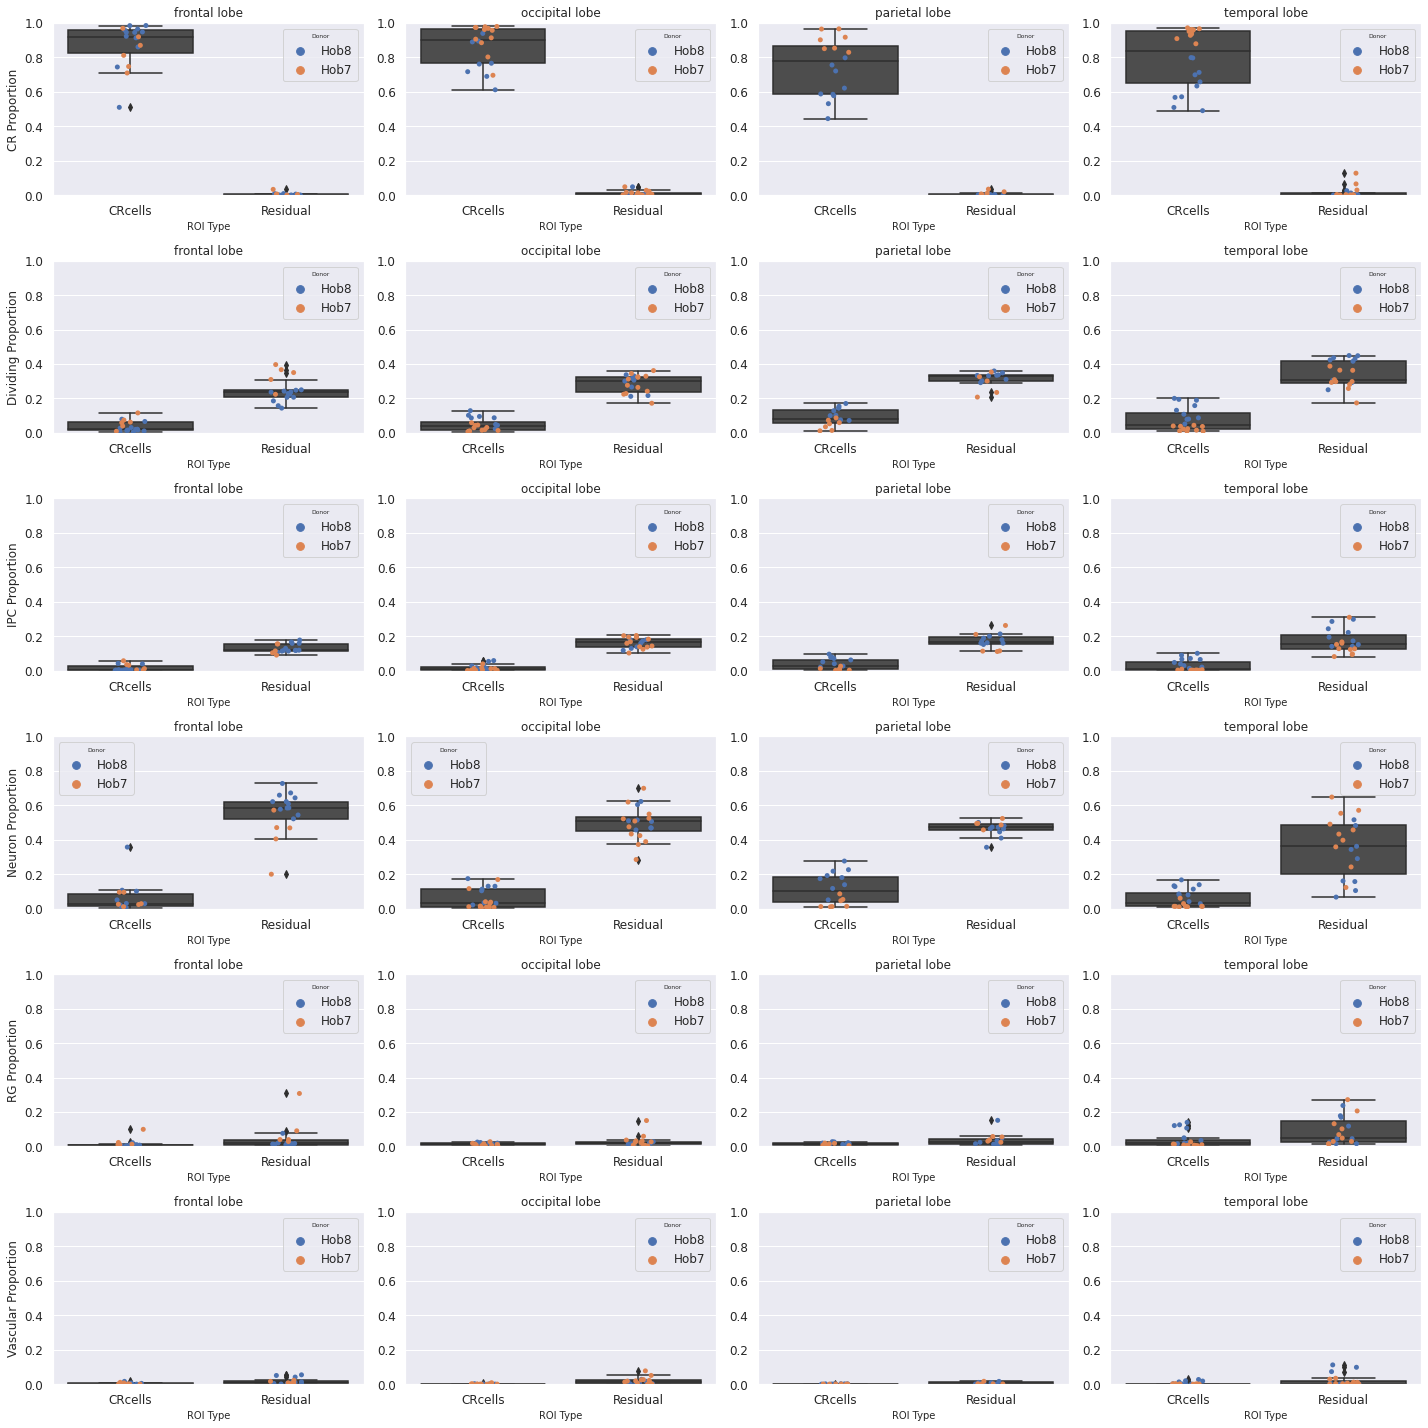

In [83]:
import matplotlib
import matplotlib.pyplot as plt

SMALL_SIZE = 12
MEDIUM_SIZE = 12
BIGGER_SIZE = 12

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

fig, ax = plt.subplots(6,4,figsize = (20,20))

unique_regions = np.unique(df['BrainRegion'])
unique_celltypes = np.unique(df['Celltype'])

for i in range(len(unique_regions)):
    for j in range(len(unique_celltypes)):
        subset = [df['BrainRegion'].iloc[k] == unique_regions[i] and df['Celltype'].iloc[k] == unique_celltypes[j]
                 for k in range(len(df['BrainRegion']))]
        sns.stripplot(x="ROItype", y="Fraction", data=df.loc[subset,:],
                      hue = 'Donor',  ax = ax[j,i])
        sns.boxplot(x="ROItype", y="Fraction", data=df.loc[subset,:],
                    color=".3", ax = ax[j,i])
        if i == 0:
            ax[j,i].set_ylabel(unique_celltypes[j] + ' Proportion', size = 12)
        else:
            ax[j,i].set_ylabel(None)
        ax[j,i].set_xlabel('ROI Type', size = 10)
        ax[j,i].set_title(unique_regions[i].split('(')[1].split(')')[0])
        ax[j,i].set_ylim(0,1)
        plt.tight_layout()

plt.savefig('/nfs/team283/aa16/KR_NAS/CellLocationResults/LocationModelWTA_1experiments_35clusters_145locations_17746genes/CRcells_proportions_barplot_allDetail.pdf')

In [143]:
all_cell_density= pd.DataFrame(index = adata_wta.obs_names, columns = main_types_unique)
for i in range(len(main_types_unique)):
    all_cell_density.loc[:,main_types_unique[i]] = np.sum(cell_density.loc[:,main_types == main_types_unique[i]], axis = 1)
all_cell_density = (all_cell_density.T/np.sum(all_cell_density, axis = 1)).T

In [146]:
adata_wta = sc.read_h5ad(sp_data_folder + "CR_cells_AnnData.h5ad")
adadta_wta = adata_wta[np.array(all_cell_density.index),:]

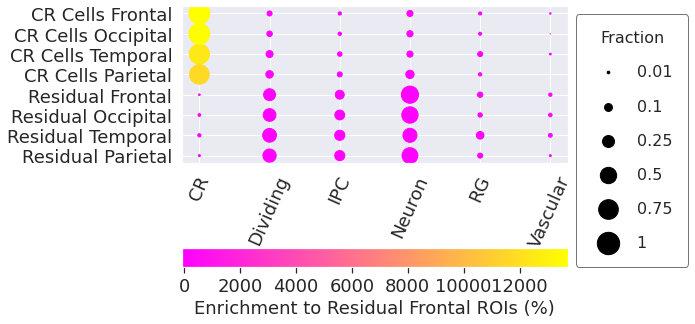

In [173]:
import matplotlib.colors as colors

# Reorder cell types:
celltypes = np.array(['CR', 'Dividing', 'IPC', 'Neuron', 'RG', 'Vascular'])
rois = np.array(['CR Cells Frontal', 'CR Cells Occipital', 'CR Cells Temporal', 'CR Cells Parietal',
                'Residual Frontal', 'Residual Occipital', 'Residual Temporal', 'Residual Parietal'])

SMALL_SIZE = 18
MEDIUM_SIZE = 18
BIGGER_SIZE = 18

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=12)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

scaling = 1000
power = 0.9

residual_frontal_index = [adata_wta.obs['Tissue'].iloc[i] == 'Foetal brain (frontal lobe)'
                          and adata_wta.obs['Pool'].iloc[i] == 'Residual'
                          for i in range(len(adata_wta.obs['Pool']))]
residual_occipital_index = [adata_wta.obs['Tissue'].iloc[i] == 'Foetal brain (occipital lobe)'
                          and adata_wta.obs['Pool'].iloc[i] == 'Residual'
                          for i in range(len(adata_wta.obs['Pool']))]
residual_temporal_index = [adata_wta.obs['Tissue'].iloc[i] == 'Foetal brain (temporal lobe)'
                          and adata_wta.obs['Pool'].iloc[i] == 'Residual'
                          for i in range(len(adata_wta.obs['Pool']))]
residual_parietal_index = [adata_wta.obs['Tissue'].iloc[i] == 'Foetal brain (parietal lobe)'
                          and adata_wta.obs['Pool'].iloc[i] == 'Residual'
                          for i in range(len(adata_wta.obs['Pool']))]
cr_frontal_index = [adata_wta.obs['Tissue'].iloc[i] == 'Foetal brain (frontal lobe)'
                          and adata_wta.obs['Pool'].iloc[i] == 'CRcells'
                          for i in range(len(adata_wta.obs['Pool']))]
cr_occipital_index = [adata_wta.obs['Tissue'].iloc[i] == 'Foetal brain (occipital lobe)'
                          and adata_wta.obs['Pool'].iloc[i] == 'CRcells'
                          for i in range(len(adata_wta.obs['Pool']))]
cr_temporal_index = [adata_wta.obs['Tissue'].iloc[i] == 'Foetal brain (temporal lobe)'
                          and adata_wta.obs['Pool'].iloc[i] == 'CRcells'
                          for i in range(len(adata_wta.obs['Pool']))]
cr_parietal_index = [adata_wta.obs['Tissue'].iloc[i] == 'Foetal brain (parietal lobe)'
                          and adata_wta.obs['Pool'].iloc[i] == 'CRcells'
                          for i in range(len(adata_wta.obs['Pool']))]

all_index = np.flipud(list([cr_frontal_index, cr_occipital_index,
                           cr_temporal_index, cr_parietal_index,
                            residual_frontal_index, residual_occipital_index,
                           residual_temporal_index, residual_parietal_index]))

countsForPlot = np.array([[np.mean(all_cell_density.iloc[:,j].iloc[all_index[k]])
                              for j in range(len(celltypes))]
                          for k in range(len(all_index))]).T

enrichmentForPlot = (-1*(1-np.array([countsForPlot[:,i]/countsForPlot[:,0] for i in range(8)]))*100).T

vcForPlot = np.flipud(np.array([rois for j in range(len(celltypes))]).flatten())

celltypesForPlot = np.repeat(celltypes,len(rois))

fig = plt.figure(figsize = (10,5))

mesh = plt.scatter(celltypesForPlot, vcForPlot, s=np.float64(((-np.amin(countsForPlot*scaling) + countsForPlot*scaling))**power),
            c= enrichmentForPlot, edgecolors='face', cmap = 'spring')
cbar = fig.colorbar(mesh, orientation="horizontal", pad = 0.3)
cbar.set_label('Enrichment to Residual Frontal ROIs (%)')

# # make a legend:
pws = [0.01, 0.01, 0.1, 0.25, 0.5, 0.75, 1]
for pw in pws:
    plt.scatter([], [], s=((-np.amin(countsForPlot*scaling) + pw*scaling))**power, c="black",label=str(pw))
h, l = plt.gca().get_legend_handles_labels()
lgd = plt.legend(h[1:], l[1:], labelspacing=1.2, title="Fraction", borderpad=1, prop={'size': 16},
            frameon=True, framealpha=0.6, edgecolor="k", facecolor="w", bbox_to_anchor=(1, 1))
plt.setp(lgd.get_title(),fontsize=16)
plt.tight_layout()
plt.xticks(rotation=66)

#plt.subplots_adjust(left = 0.25)
plt.savefig('0_publication_figures/Figure5_CelltypeEnrichment.pdf',
            bbox_inches='tight')
plt.show()